In [140]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import torch
import torchvision
import torchvision.datasets as dataset
import torch.functional as F
import torch.nn as nn
from torch.utils.data import random_split
import torchvision.transforms as transforms
from tqdm import tqdm
import os
from PIL import Image
from sklearn.preprocessing import OneHotEncoder
from torch.utils.data import Dataset
from torch.utils.data import DataLoader



In [141]:
csv_path = 'pokemon.csv'  
pokemon_data = pd.read_csv(csv_path)

type1_classes = pokemon_data['Type1'].unique()
type2_classes = pokemon_data['Type2'].dropna().unique()

type1_to_label = {cls: idx + 1 for idx, cls in enumerate(type1_classes)}
type2_to_label = {cls: idx + 1 for idx, cls in enumerate(type2_classes)}

def map_to_labels(type_name, label_map):
    return pokemon_data[type_name].apply(lambda x: label_map.get(x, 0))

pokemon_data['Type1'] = map_to_labels('Type1', type1_to_label)
pokemon_data['Type2'] = map_to_labels('Type2', type2_to_label)

pokemon_data.drop('Evolution',axis=1,inplace=True)

pokemon_data

,Name,Type1,Type2
0,bulbasaur,1,1
1,ivysaur,1,1
2,venusaur,1,1
3,charmander,2,0
4,charmeleon,2,0
...,...,...,...
804,stakataka,12,8
805,blacephalon,2,16
806,zeraora,7,0
807,meltan,17,0


In [142]:

dict = {v: k for k, v in type1_to_label.items()}

dict[0] = 'NIL'
dict

{1: 'Grass',
 2: 'Fire',
 3: 'Water',
 4: 'Bug',
 5: 'Normal',
 6: 'Poison',
 7: 'Electric',
 8: 'Ground',
 9: 'Fairy',
 10: 'Fighting',
 11: 'Psychic',
 12: 'Rock',
 13: 'Ghost',
 14: 'Ice',
 15: 'Dragon',
 16: 'Dark',
 17: 'Steel',
 18: 'Flying',
 0: 'NIL'}

In [143]:
num_classes = len(type1_classes) + 1
num_classes

19

In [144]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),  
    transforms.ToTensor(),  
])

In [145]:
class PokemonDataset(Dataset):
    def __init__(self, pokemon_data, image_folder, transform=None):
        self.pokemon_data = pokemon_data
        self.image_folder = image_folder
        self.transform = transform
    
    def __len__(self):
        return len(self.pokemon_data)
    
    def __getitem__(self, idx):
        pokemon_name = self.pokemon_data.loc[idx, 'Name']
        img_name = pokemon_name + '.png' 
        img_path = os.path.join(self.image_folder, img_name)
        image = Image.open(img_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
        
        type1 = self.pokemon_data.loc[idx, 'Type1']
        type2 = self.pokemon_data.loc[idx, 'Type2']
        
        return image, torch.tensor(type1, dtype=torch.long), torch.tensor(type2, dtype=torch.long)


image_folder = 'images'

dataset = PokemonDataset(pokemon_data=pokemon_data, image_folder=image_folder, transform=transform)

image, type1, type2 = dataset[0]
print(image.shape, type1, type2)

torch.Size([3, 128, 128]) tensor(1) tensor(1)


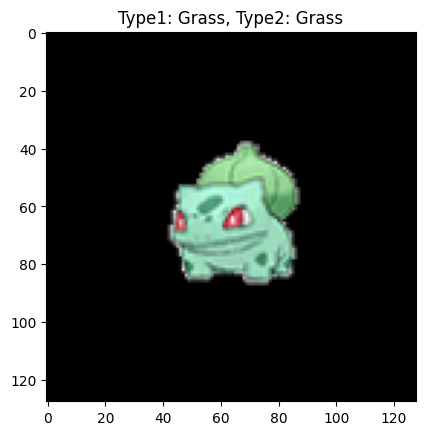

In [146]:

image, type1, type2 = dataset[0]

type1 = type1.item()
type2 = type2.item()
plt.imshow(image.permute(1, 2, 0))  
plt.title(f'Type1: {dict[type1]}, Type2: {dict[type2]}')  
plt.axis('on')  

plt.show()

In [147]:
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

In [148]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [150]:
class BasicConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, **kwargs):
        super(BasicConv2d, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, **kwargs)
        self.relu = nn.ReLU(inplace=True)
        
    def forward(self, x):
        x = self.conv(x)
        x = self.relu(x)
        return x

class InceptionModule(nn.Module):
    def __init__(self, in_channels, conv1x1_out, conv3x3_reduce, conv3x3_out,
                 conv5x5_reduce, conv5x5_out, pool_proj):
        super(InceptionModule, self).__init__()
        
        # 1x1 conv branch
        self.branch1x1 = BasicConv2d(in_channels, conv1x1_out, kernel_size=1)
        
        # 1x1 conv followed by 3x3 conv branch
        self.branch3x3 = nn.Sequential(
            BasicConv2d(in_channels, conv3x3_reduce, kernel_size=1),
            BasicConv2d(conv3x3_reduce, conv3x3_out, kernel_size=3, padding=1)
        )
        
        # 1x1 conv followed by 5x5 conv branch
        self.branch5x5 = nn.Sequential(
            BasicConv2d(in_channels, conv5x5_reduce, kernel_size=1),
            BasicConv2d(conv5x5_reduce, conv5x5_out, kernel_size=5, padding=2)
        )
        
        # 3x3 max pooling followed by 1x1 conv branch
        self.branch_pool = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
            BasicConv2d(in_channels, pool_proj, kernel_size=1)
        )
        
    def forward(self, x):
        branch1x1 = self.branch1x1(x)
        branch3x3 = self.branch3x3(x)
        branch5x5 = self.branch5x5(x)
        branch_pool = self.branch_pool(x)
        
        outputs = [branch1x1, branch3x3, branch5x5, branch_pool]
        return torch.cat(outputs, 1)

In [166]:
class PokeCeption(nn.Module):
    def __init__(self, num_classes):
        super(PokeCeption, self).__init__()
        
        # Convolutional layers
        self.conv1 = BasicConv2d(3, 64, kernel_size=7, stride=2, padding=3)  # Output: 64x64x64
        self.maxpool1 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)      # Output: 32x32x64
        
        self.conv2 = BasicConv2d(64, 64, kernel_size=1)                       # Output: 32x32x64
        self.conv3 = BasicConv2d(64, 192, kernel_size=3, padding=1)           # Output: 32x32x192
        self.maxpool2 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)      # Output: 16x16x192
        
        # Inception modules
        self.inception3a = InceptionModule(192, 64, 96, 128, 16, 32, 32)       # Output: 16x16x256
        self.inception3b = InceptionModule(256, 128, 128, 192, 32, 96, 64)     # Output: 16x16x480
        self.maxpool3 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)      # Output: 8x8x480
        
        self.inception4a = InceptionModule(480, 192, 96, 208, 16, 48, 64)      # Output: 8x8x512
        self.inception4b = InceptionModule(512, 160, 112, 224, 24, 64, 64)     # Output: 8x8x512
        self.inception4c = InceptionModule(512, 128, 128, 256, 24, 64, 64)     # Output: 8x8x512
        self.inception4d = InceptionModule(512, 112, 144, 288, 32, 64, 64)     # Output: 8x8x528
        self.inception4e = InceptionModule(528, 256, 160, 320, 32, 128, 128)   # Output: 8x8x832
        self.maxpool4 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)      # Output: 4x4x832
        
        # Final layers for each classifier
        self.inception5a = InceptionModule(832, 256, 160, 320, 32, 128, 128)   # Output: 4x4x832
        self.inception5b = InceptionModule(832, 384, 192, 384, 48, 128, 128)   # Output: 4x4x1024
        
        # Classifier blocks
        self.avgpool1 = nn.AdaptiveAvgPool2d((1, 1))                           # Output: 1x1x1024
        self.dropout1 = nn.Dropout(p=0.4)
        self.fc1 = nn.Linear(1024, num_classes)                              # Output: 1x1xnum_classes1
        
        self.avgpool2 = nn.AdaptiveAvgPool2d((1, 1))                           # Output: 1x1x1024
        self.dropout2 = nn.Dropout(p=0.4)
        self.fc2 = nn.Linear(1024, num_classes)                              # Output: 1x1xnum_classes2

    def forward(self, x):
        # Initial layers
        x = self.conv1(x)
        x = self.maxpool1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.maxpool2(x)
        
        # Inception blocks
        x = self.inception3a(x)
        x = self.inception3b(x)
        x = self.maxpool3(x)
        
        x = self.inception4a(x)
        x = self.inception4b(x)
        x = self.inception4c(x)
        x = self.inception4d(x)
        x = self.inception4e(x)
        x = self.maxpool4(x)
        
        # Final layers
        x = self.inception5a(x)
        x = self.inception5b(x)
        
        # Classifier 1
        out1 = self.avgpool1(x)
        out1 = torch.flatten(out1, 1)
        out1 = self.dropout1(out1)
        out1 = self.fc1(out1)
        
        # Classifier 2
        out2 = self.avgpool2(x)
        out2 = torch.flatten(out2, 1)
        out2 = self.dropout2(out2)
        out2 = self.fc2(out2)
        
        return out1, out2

In [152]:
device = torch.device('cuda')

In [167]:
model = PokeCeption(19).to(device)
model


PokeCeption(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (relu): ReLU(inplace=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
    (relu): ReLU(inplace=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu): ReLU(inplace=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (inception3a): InceptionModule(
    (branch1x1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1))
      (relu): ReLU(inplace=True)
    )
    (branch3x3): Sequential(
      (0): BasicConv2d(
        (conv): Conv2d(192, 96, kernel_size=(1, 1), stride=(1, 1))
        (relu): ReLU(inplace=True)
      )
      (1): BasicConv2d(
        (conv): Conv2d(96, 128, kernel_size=(3, 3), stride=

In [154]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
num_epochs = 35


In [155]:
def calculate_accuracy(outputs, labels):
    _, predicted = torch.max(outputs, 1)
    correct = (predicted == labels).sum().item()
    accuracy = correct / labels.size(0) * 100.0
    return accuracy

In [156]:
train_losses = []
train_acc_type1 = []
train_acc_type2 = []

In [157]:
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    total_type1 = 0
    correct_type1 = 0
    total_type2 = 0
    correct_type2 = 0
    
    for images, type1_labels, type2_labels in train_loader:
        images = images.to(device)
        type1_labels = type1_labels.to(device)
        type2_labels = type2_labels.to(device)
        
        optimizer.zero_grad()
        outputs_type1, outputs_type2 = model(images)
        
        loss_type1 = criterion(outputs_type1, type1_labels)
        loss_type2 = criterion(outputs_type2, type2_labels)
        loss = (loss_type1 + loss_type2)/2
        
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        total_type1 += type1_labels.size(0)
        correct_type1 += (torch.argmax(outputs_type1, dim=1) == type1_labels).sum().item()
        
        total_type2 += type2_labels.size(0)
        correct_type2 += (torch.argmax(outputs_type2, dim=1) == type2_labels).sum().item()
    
    epoch_loss = running_loss / len(train_loader)
    accuracy_type1 = correct_type1 / total_type1 * 100.0
    accuracy_type2 = correct_type2 / total_type2 * 100.0
    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss:.4f}, Type1 Accuracy: {accuracy_type1:.2f}%, Type2 Accuracy: {accuracy_type2:.2f}%")
    
    train_losses.append(epoch_loss)
    train_acc_type1.append(accuracy_type1)
    train_acc_type2.append(accuracy_type2)

Epoch [1/35], Loss: 2.6177, Type1 Accuracy: 10.97%, Type2 Accuracy: 44.67%
Epoch [2/35], Loss: 2.3326, Type1 Accuracy: 21.02%, Type2 Accuracy: 50.08%
Epoch [3/35], Loss: 2.2584, Type1 Accuracy: 23.49%, Type2 Accuracy: 50.23%
Epoch [4/35], Loss: 2.1552, Type1 Accuracy: 28.13%, Type2 Accuracy: 49.61%
Epoch [5/35], Loss: 2.0670, Type1 Accuracy: 31.99%, Type2 Accuracy: 49.92%
Epoch [6/35], Loss: 1.9569, Type1 Accuracy: 36.17%, Type2 Accuracy: 52.70%
Epoch [7/35], Loss: 1.8048, Type1 Accuracy: 41.89%, Type2 Accuracy: 54.25%
Epoch [8/35], Loss: 1.6084, Type1 Accuracy: 43.12%, Type2 Accuracy: 59.20%
Epoch [9/35], Loss: 1.4559, Type1 Accuracy: 53.17%, Type2 Accuracy: 60.74%
Epoch [10/35], Loss: 1.3172, Type1 Accuracy: 59.97%, Type2 Accuracy: 63.52%
Epoch [11/35], Loss: 1.2166, Type1 Accuracy: 67.08%, Type2 Accuracy: 62.29%
Epoch [12/35], Loss: 1.1179, Type1 Accuracy: 70.63%, Type2 Accuracy: 65.38%
Epoch [13/35], Loss: 1.0359, Type1 Accuracy: 75.27%, Type2 Accuracy: 66.77%
Epoch [14/35], Loss: 

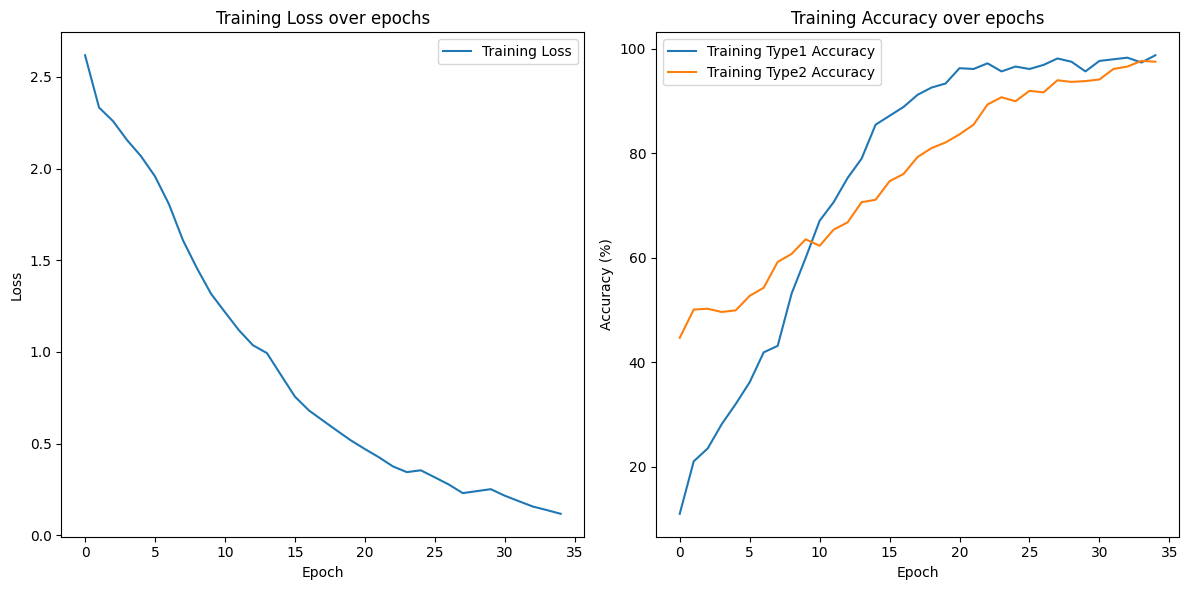

In [158]:


plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_acc_type1, label='Training Type1 Accuracy')
plt.plot(train_acc_type2, label='Training Type2 Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training Accuracy over epochs')
plt.legend()

plt.tight_layout()
plt.show()



In [159]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

y_true_type1, y_pred_type1 = [], []
y_true_type2, y_pred_type2 = [], []

model.eval()

for images, type1_labels, type2_labels in train_loader:
    images = images.to(device)
    type1_labels = type1_labels.to(device)
    type2_labels = type2_labels.to(device)
    
    outputs_type1, outputs_type2 = model(images)
    
    _, predicted_type1 = torch.max(outputs_type1, 1)
    _, predicted_type2 = torch.max(outputs_type2, 1)
    
    y_true_type1.extend(type1_labels.cpu().numpy())
    y_pred_type1.extend(predicted_type1.cpu().numpy())
    
    y_true_type2.extend(type2_labels.cpu().numpy())
    y_pred_type2.extend(predicted_type2.cpu().numpy())

y_true_type1 = np.array(y_true_type1)
y_pred_type1 = np.array(y_pred_type1)

y_true_type2 = np.array(y_true_type2)
y_pred_type2 = np.array(y_pred_type2)




In [160]:
print("Classification Report for Type1:")
print(classification_report(y_true_type1, y_pred_type1))


Classification Report for Type1:
              precision    recall  f1-score   support

           1       1.00      1.00      1.00        66
           2       1.00      1.00      1.00        43
           3       1.00      1.00      1.00        94
           4       1.00      0.98      0.99        59
           5       1.00      1.00      1.00        86
           6       1.00      1.00      1.00        26
           7       1.00      1.00      1.00        35
           8       1.00      1.00      1.00        23
           9       1.00      1.00      1.00        14
          10       1.00      1.00      1.00        19
          11       1.00      1.00      1.00        41
          12       0.97      1.00      0.99        34
          13       1.00      1.00      1.00        20
          14       1.00      1.00      1.00        18
          15       1.00      1.00      1.00        24
          16       0.96      1.00      0.98        24
          17       1.00      1.00      1.00     

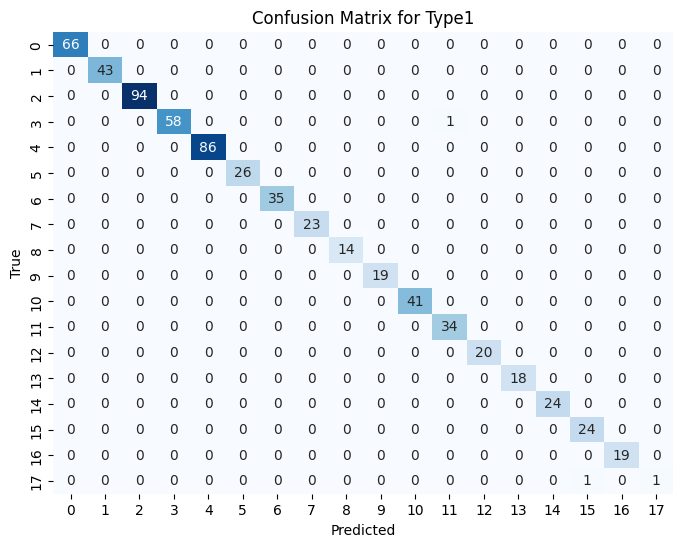

In [161]:



plt.figure(figsize=(8, 6))
cm_type1 = confusion_matrix(y_true_type1, y_pred_type1)
sns.heatmap(cm_type1, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for Type1')
plt.show()



In [162]:
print("Classification Report for Type2:")
print(classification_report(y_true_type2, y_pred_type2))

Classification Report for Type2:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       324
           1       0.96      1.00      0.98        26
           2       1.00      1.00      1.00        77
           3       1.00      1.00      1.00        27
           4       1.00      1.00      1.00        25
           5       1.00      1.00      1.00        15
           6       0.95      1.00      0.98        21
           7       1.00      1.00      1.00        20
           8       1.00      1.00      1.00        20
           9       1.00      1.00      1.00         8
          10       1.00      0.92      0.96        12
          11       0.86      1.00      0.92        12
          12       1.00      1.00      1.00         8
          13       1.00      1.00      1.00         7
          14       1.00      1.00      1.00        13
          15       1.00      1.00      1.00        12
          16       1.00      0.92      0.96     

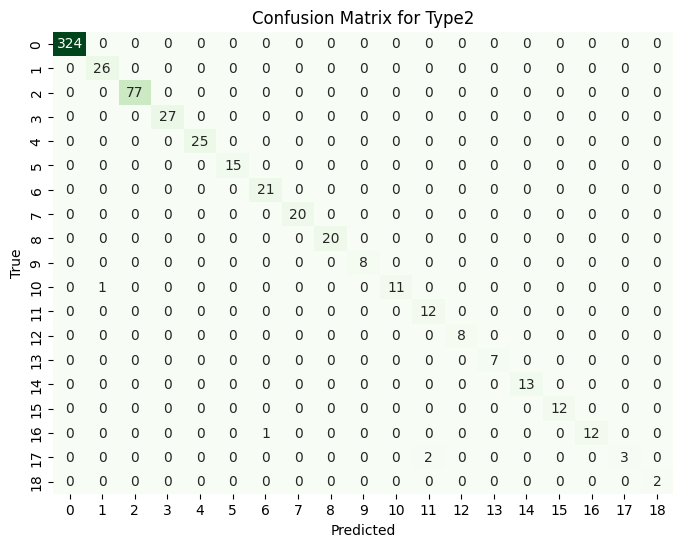

In [163]:
plt.figure(figsize=(8, 6))
cm_type2 = confusion_matrix(y_true_type2, y_pred_type2)
sns.heatmap(cm_type2, annot=True, fmt='d', cmap='Greens', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for Type2')
plt.show()

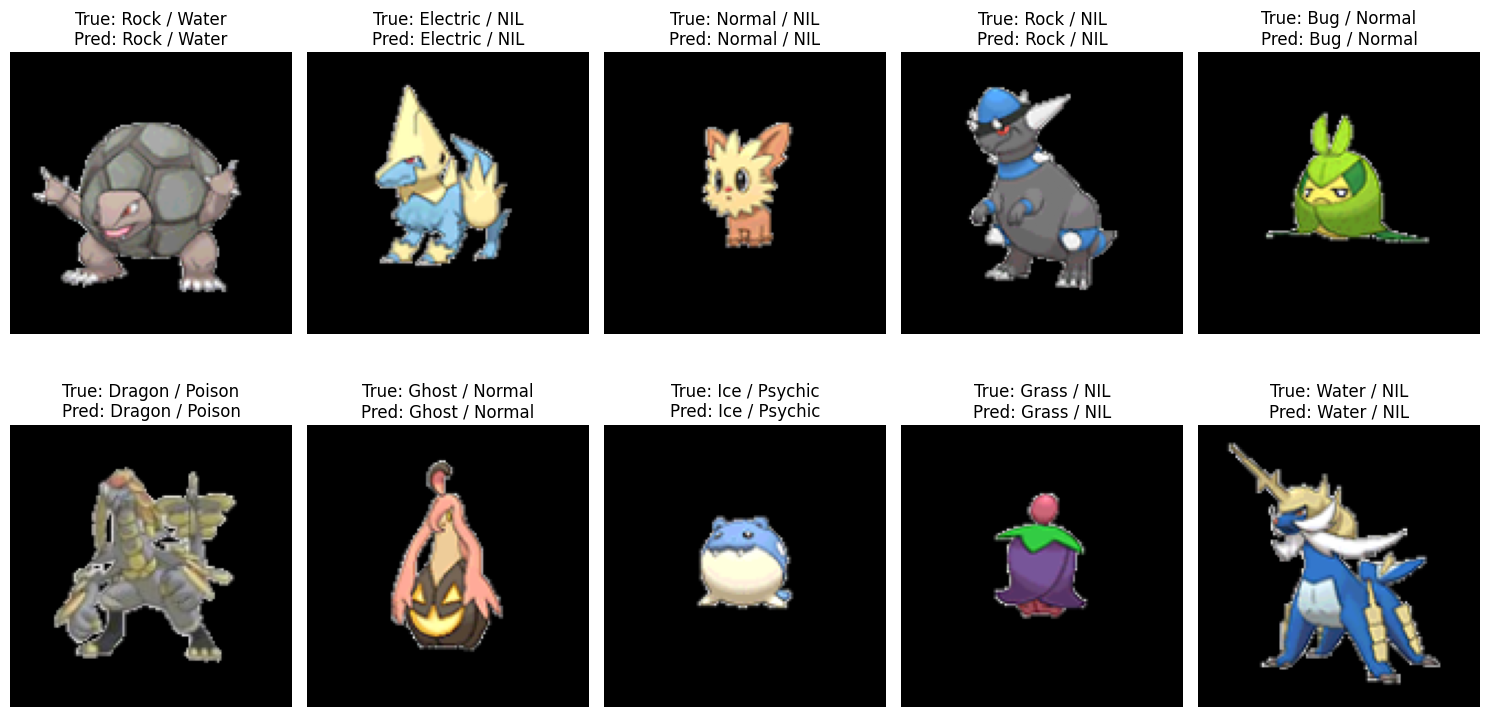

In [164]:
import random

model.eval()

random_indices = random.sample(range(len(train_dataset)), 10)

images_to_display = []
true_classes_type1 = []
true_classes_type2 = []
predicted_classes_type1 = []
predicted_classes_type2 = []

for idx in random_indices:
    image, true_type1, true_type2 = train_dataset[idx]
    
    image = image.unsqueeze(0).to(device)
    
    outputs_type1, outputs_type2 = model(image)
    
    _, predicted_type1 = torch.max(outputs_type1, 1)
    _, predicted_type2 = torch.max(outputs_type2, 1)
    
    images_to_display.append(image)
    true_classes_type1.append(dict[true_type1.item()])
    true_classes_type2.append(dict[true_type2.item()])
    predicted_classes_type1.append(dict[predicted_type1.item()])
    predicted_classes_type2.append(dict[predicted_type2.item()])

plt.figure(figsize=(15, 8))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    image = images_to_display[i].squeeze(0).permute(1, 2, 0).cpu().numpy()
    plt.imshow(image)
    plt.title(f'True: {true_classes_type1[i]} / {true_classes_type2[i]}\nPred: {predicted_classes_type1[i]} / {predicted_classes_type2[i]}')
    plt.axis('off')
plt.tight_layout()
plt.show()
